In [1]:
import numpy as np
import seaborn as sns
import struct
import  pymysql
import  pymysql.cursors

In [2]:
db = pymysql.connect(host='localhost',
                           user='root',
                           password='xzx970413',
                           db='Wechat_inf',
                           port=3306,
                           charset='utf8')

cur = db.cursor()

sql = "select * from User_inf"
try:
	cur.execute(sql) 
 
	results = cur.fetchall()
	print("id","borrow","repay")
	#遍历结果
	for row in results :
		id = row[0]
		name = row[-2].decode("utf-8")
		password = row[-1].decode("utf-8") 
		print(id,name,password)
except Exception as e:
	raise e
finally:
	db.close()


id borrow repay
1435223 1  0 
172344 1  1 
18661377320 1  0 
1927233 1  1 
234567 1  0 
25233 1  1 
2667623 0  1 
34332423 0  1 
657851236 1  1 
7223654 0  0 
783423 0  1 


In [3]:
from pandas import DataFrame
data  = DataFrame(list(results))
print (data.describe().T)

   count  mean       std   min    25%   50%    75%   max
1   10.0  34.0  8.151346  21.0  27.25  37.5  40.75  43.0
2   10.0   9.4  7.244922   0.0   2.75  11.0  14.50  20.0


In [4]:
data.columns = np.asarray(cur.description)[:, 0]
data['Borrow'] = data['Borrow'].map(lambda x: x.decode("utf-8"))
data['Repay'] = data['Repay'].map(lambda x: x.decode("utf-8"))
data

,User_id,User_Age,User_Work_year,Income,Debt,Borrow,Repay
0,1435223,24.0,2.0,28.00,17.30,1 ,0 
1,172344,40.0,15.0,120.00,2.90,1 ,1 
2,18661377320,NaN,NaN,0.00,0.00,1 ,0 
3,1927233,43.0,12.0,38.00,3.60,1 ,1 
4,234567,41.0,17.0,176.00,9.30,1 ,0 
5,25233,39.0,20.0,67.00,30.60,1 ,1 
6,2667623,28.0,10.0,31.00,17.30,0 ,1 
7,34332423,27.0,0.0,16.00,1.70,0 ,1 
8,657851236,21.0,0.0,0.00,0.00,1 ,1 
9,7223654,36.0,13.0,25.00,19.70,0 ,0 


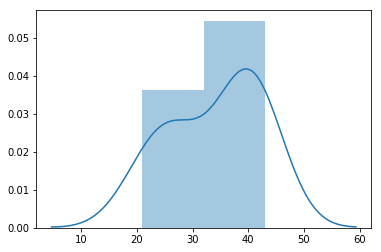

In [8]:
data1 = data[u'User_Age'].dropna()
sns.distplot([data1])